## Notebook for face verification

In [0]:
!kill -9 -1

In [1]:
!nvidia-smi

Mon May 18 15:16:01 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
import tensorflow as tf
import tensorflow.keras as K
import os
import cv2
import PIL.Image
import numpy as np
import sys
np.set_printoptions(threshold=sys.maxsize)

print(tf.__version__)
print(K.__version__)

2.2.0
2.3.0-tf


In [0]:
#Connect with drive

from google.colab import drive
drive.mount('/content/drive')

In [0]:
# read data from drive
with open('drive/My Drive/Face Verification/haarcascade_frontalface_default.xml', 'r') as f:
    haar_file = f.read()

#print(haar_file)
#with open('drive/My Drive/Smart Reply/10000_labels.csv', 'r') as f:
    #labels = f.read()

In [4]:
if not os.path.exists('dataset'):
    os.mkdir('dataset')

if not os.path.exists('dataset_gray'):
    os.mkdir('dataset_gray')

!unzip 'drive/My Drive/Face Verification/faces_mixed.zip' -d dataset

dir_contents = os.listdir('dataset/faces_mixed')
print(len(dir_contents))

Archive:  drive/My Drive/Face Verification/faces_mixed.zip
   creating: dataset/faces_mixed/
   creating: dataset/faces_mixed/9326871/
  inflating: dataset/faces_mixed/9326871/9326871.1.jpg  
  inflating: dataset/faces_mixed/9326871/9326871.10.jpg  
  inflating: dataset/faces_mixed/9326871/9326871.11.jpg  
  inflating: dataset/faces_mixed/9326871/9326871.12.jpg  
  inflating: dataset/faces_mixed/9326871/9326871.13.jpg  
  inflating: dataset/faces_mixed/9326871/9326871.14.jpg  
  inflating: dataset/faces_mixed/9326871/9326871.15.jpg  
  inflating: dataset/faces_mixed/9326871/9326871.16.jpg  
  inflating: dataset/faces_mixed/9326871/9326871.17.jpg  
  inflating: dataset/faces_mixed/9326871/9326871.18.jpg  
  inflating: dataset/faces_mixed/9326871/9326871.19.jpg  
  inflating: dataset/faces_mixed/9326871/9326871.2.jpg  
  inflating: dataset/faces_mixed/9326871/9326871.20.jpg  
  inflating: dataset/faces_mixed/9326871/9326871.3.jpg  
  inflating: dataset/faces_mixed/9326871/9326871.4.jpg  

# Take 20 photos

In [0]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

# All the faces data will be present this folder 
dataset = './dataset'

if not os.path.exists(dataset):
    os.mkdir(dataset)
sub_data = input("Enter your username: ")
#sub_data_gray = input("Enter your username for gray scale: ")

# Use the username as path name
path = os.path.join(dataset, sub_data) 
path_gray = 'dataset/{}{}'.format(sub_data,'_gray')

# Add a verfication for this step
if not os.path.exists(path):
    os.mkdir(path)
    os.mkdir(path_gray)    

def take_photo(filename='dataset/name/photo.jpg', quality=1):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

Enter your username: george


In [0]:
from IPython.display import Image

# Take 20 photos
for i in range(20):
  try:
    filename = take_photo(filename='dataset/{}/photo{}.jpg'.format(sub_data,i))
    print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
    #display(Image(filename))
  except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
    print(str(err))



In [0]:
# zip saved model folder
!zip -r /content/dataset/george.zip /content/dataset/george

## If you come later unzip the file with photos

In [0]:
if not os.path.exists('dataset'):
    os.mkdir('dataset')

if not os.path.exists('dataset_gray'):
    os.mkdir('dataset_gray')

!unzip george.zip -d dataset
!unzip Kim.zip -d dataset
!unzip Bean.zip -d dataset

## Transform photos to specific shape

### For faces_mixed folder

In [0]:
#!rm -rf dataset
!rm -rf dataset_gray

if not os.path.exists('dataset'):
    os.mkdir('dataset')

if not os.path.exists('dataset_gray'):
    os.mkdir('dataset_gray')

In [0]:

# Transform all photos of faces_mixed folder to 180,200 and BGR2RGB

def create_dataset_faces(folder):

    path_gray = 'dataset_gray/{}'.format(folder)
    # Add a verfication for this step
    if not os.path.exists(path_gray):
        os.mkdir(path_gray) 

    sub_data = folder

    # The file containing the pretrained classifier 
    haar_file = 'drive/My Drive/Face Verification/haarcascade_frontalface_default.xml'
        
    # Image to be resized to this shape
    (width, height) = (180, 200)     
    
    # Make the cascade classifier object
    face_cascade = cv2.CascadeClassifier(haar_file) 
    #webcam = cv2.VideoCapture(0)  

    # The program loops until it has 20 images of the face. 
    for image in os.listdir('dataset/faces_mixed/{}'.format(folder)):
        # Read from file
        # Creates blueish file
        im = PIL.Image.open('dataset/faces_mixed/{}/{}'.format(folder,image))
        # Creates images with normal color
        #im = cv2.imread('dataset/{}/photo{}.jpg'.format(sub_data,count))
        im = np.array(im)
        #print(im.shape)
        
        # Convert to grayscale
        gray = cv2.cvtColor(im, cv2.COLOR_BGR2RGB) 
        # Resize (if neccessary)
        face_resize = cv2.resize(gray, (width, height))
        #print(face_resize.shape)
        cv2.imwrite('% s/% s.jpg' % (path_gray, str(image)), face_resize) 
        

# Call this function to convert all images inside master folder
for folder in os.listdir('dataset/faces_mixed'):
    create_dataset_faces(folder)

In [6]:
dir_contents_gray = os.listdir('dataset_gray')
print(len(dir_contents_gray))

151


## Other .zip files

In [0]:

path_gray_george = 'dataset_gray/{}'.format('george')

# Add a verfication for this step
if not os.path.exists(path_gray_george):
    os.mkdir(path_gray_george) 

sub_data = 'george'

def create_dataset_george():
    # The file containing the pretrained classifier 
    haar_file = 'drive/My Drive/Face Verification/haarcascade_frontalface_default.xml'
        
    # Image to be resized to this shape
    (width, height) = (180, 200)     
    
    # Make the cascade classifier object
    face_cascade = cv2.CascadeClassifier(haar_file) 
    #webcam = cv2.VideoCapture(0)  

    # The program loops until it has 20 images of the face. 
    count = 0
    while count < 20:
        # Read from file
        # Creates blueish file
        im = PIL.Image.open('dataset/{}/photo{}.jpg'.format(sub_data,count))
        # Creates images with normal color
        #im = cv2.imread('dataset/{}/photo{}.jpg'.format(sub_data,count))
        im = np.array(im)
        #print(im.shape)
        
        # Convert to grayscale
        gray = cv2.cvtColor(im, cv2.COLOR_BGR2RGB) 
        # Detect the face
        faces = face_cascade.detectMultiScale(gray, 1.3, 4) 
        
        face_resize = None
        for (x, y, w, h) in faces:
            # The classifier seemed to scrap the chin and hair. Adjustments made to accomodate those.
            face = im[y-60 : y+h+60, x-20 : x+w+20] 
            face_resize = cv2.resize(face, (width, height)) 
            cv2.imwrite('% s/% s.png' % (path_gray_george, 'photoGeorge{}'.format(count)), face_resize) 
        count += 1

        #cv2.imshow('OpenCV', im) 
        #key = cv2.waitKey(100) 
        #if key == 27: 
            #break

# Call this function whenever you need to create a dataset of the person's images
create_dataset_george()

In [0]:

path_gray_Bean = 'dataset_gray/{}'.format('Bean')

# Add a verfication for this step
if not os.path.exists(path_gray_Bean):
    os.mkdir(path_gray_Bean) 

sub_data = 'Bean'
dir_contents_Bean = os.listdir('dataset/Bean')
print(len(dir_contents_Bean))

def create_dataset_Bean():
   
    # Image to be resized to this shape
    (width, height) = (180, 200) 

    # The program loops until it has 20 images of the face. 
    count = 0
    while count < 20:
        # Read from file
        # Creates blueish file
        im = PIL.Image.open('dataset/Bean/{}'.format(dir_contents_Bean[count]))
        print('dataset/Bean/{}'.format(dir_contents_Bean[count]))
        # Creates images with normal color
        #im = cv2.imread('dataset/Bean/{}.jpg'.format(dir_contents_Bean[count]))
        im = np.array(im)
        print(im.shape)
        
        # Convert to grayscale
        gray = cv2.cvtColor(im, cv2.COLOR_BGR2RGB) 

        face_resize = cv2.resize(gray, (width, height))
        print(face_resize.shape)

        cv2.imwrite('% s/% s.png' % (path_gray_Bean, 'photoBean{}'.format(count)), face_resize) 
        #cv2.waitKey()

        count += 1

# Call this function whenever you need to create a dataset of the person's images
create_dataset_Bean()

In [0]:

path_gray_Kim = 'dataset_gray/{}'.format('Kim')

# Add a verfication for this step
if not os.path.exists(path_gray_Kim):
    os.mkdir(path_gray_Kim) 

sub_data = 'Kim'
dir_contents_Kim = os.listdir('dataset/Kim')
print(len(dir_contents_Kim))

def create_dataset_Kim():  
    # Image to be resized to this shape
    (width, height) = (180, 200)      

    # The program loops until it has 20 images of the face. 
    count = 0
    while count < 20:
        # Read from file
        im = PIL.Image.open('dataset/Kim/{}'.format(dir_contents_Kim[count]))
        print('dataset/Bean/{}'.format(dir_contents_Kim[count]))
        im = np.array(im)
        print(im.shape)
        
        # Convert to grayscale
        gray = cv2.cvtColor(im, cv2.COLOR_BGR2RGB) 

        face_resize = cv2.resize(gray, (width, height))
        print(face_resize.shape)

        cv2.imwrite('% s/% s.png' % (path_gray_Kim, 'photoKim{}'.format(count)), face_resize) 

        count += 1

# Call this function whenever you need to create a dataset of the person's images
create_dataset_Kim()

## Import Keras layers

In [0]:
a = []
while(1):
    a.append('1')

In [7]:
from tensorflow.keras import backend as K, models
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from keras.layers.normalization import BatchNormalization
from tensorflow.keras.applications import VGG16, MobileNetV2
from tensorflow.keras.regularizers import l2
from tensorflow.keras.activations import relu
from tensorflow.keras.callbacks import EarlyStopping
import os
from os.path import join as join_
import numpy as np
from PIL import Image
import datetime

Using TensorFlow backend.


Triplets are formed and stored in the triplets list (in the code attached below). For each person(person identified by a folder inside the dataset folder), we store 5 triplets of (A, P, N). They are then trained over the model which in itself consists of three VGG16 or MobileNetV2 models, joined by a Lambda layer which implements the triplet loss function.

In [8]:
# Setting up the dataset

SET_DIR = 'dataset_gray/'
NUM_CLASSES = len(os.listdir('dataset_gray'))
print(NUM_CLASSES)

# The shape which VGG16 accepts as input and thus each image is resized to
image_shape = (224, 224, 3)

# NUM_EXAMPLES is the number of (A,P,N) triplets chosen for the same class (N belongs to a different class of course)
NUM_EXAMPLES = 2

# Triplets list will contain anchor(A), positive(P) and negative(N) triplets.
triplets = []
A = P = N = []
A_str = P_str = N_str = []

# creating anchor, positive, negative triplets
for _ in range(NUM_EXAMPLES):
    for direc in os.listdir(SET_DIR):
        dir_path = SET_DIR + direc
        dir_contents = os.listdir(dir_path)
        length = len(dir_contents)
        #print(length)
        
        A_ran = dir_contents[np.random.randint(0, length)]
        A_str = Image.open(join_(dir_path, A_ran))
        anchor = np.asarray(A_str)/255
        # anchor.shape = (200, 180, 3)        
        # Padding with zeros for each channel in RGB
        anchor = np.array([np.pad(a, ((22,22), (12,12)), 'constant') for a in anchor.T]).T
        
        P_ran = dir_contents[np.random.randint(0, length)]
        P_str = Image.open(join_(dir_path, P_ran))
        positive = np.asarray(P_str)/255
        positive = np.array([np.pad(a, ((22,22), (12,12)), 'constant') for a in positive.T]).T
        
        neg_dir = os.listdir(SET_DIR)[np.random.randint(NUM_CLASSES)]
        while neg_dir == direc: 
            neg_dir = os.listdir(SET_DIR)[np.random.randint(NUM_CLASSES)]
            
        length_negative = len(os.listdir(SET_DIR + neg_dir))
        N_ran = os.listdir(SET_DIR + neg_dir)[np.random.randint(0, length_negative)]
        N_str = Image.open(join_(SET_DIR + neg_dir, N_ran))
        negative = np.asarray(N_str)/255        
        negative = np.array([np.pad(a, ((22,22), (12,12)), 'constant') for a in negative.T]).T
        
        # append triplet
        triplets.append([anchor, positive, negative])
        A.append(anchor)
        P.append(positive)
        N.append(negative)

        #triplets.append([A_ran, P_ran, N_ran])
        #A.append(A_ran)
        #P.append(P_ran)
        #N.append(N_ran)


151


In [0]:
#print(triplets[0:1])
#print(A[0])
#print(P[0])
#print(N[0])

In [11]:
print(len(triplets))
print(type(triplets))
print(type(A))
print(type(negative))

302
<class 'list'>
<class 'list'>
<class 'numpy.ndarray'>


## Triplet loss [function](https://en.wikipedia.org/wiki/Triplet_loss)

In [0]:
def triplet_function(vects, alpha=0.2):
    x, y, z = vects
    sum_square_xy = K.sum(K.square(x - y), axis=1, keepdims=True)
    sum_square_xz = K.sum(K.square(x - z), axis=1, keepdims=True)
    return K.sum(K.maximum(sum_square_xy - sum_square_xz + alpha, 0), axis=0)

In [0]:
# Using the VGG16 or MobileNetV2 model defined in keras.applications

def VGG():
    image_input = Input(shape=(224, 224, 3))
    model = MobileNetV2(input_tensor=image_input, weights='imagenet', include_top=True)
    #model.layers[-1].activation = relu
    x_out = Dense(64)(model.layers[-1].output)
    
    new_model = Model(inputs=image_input, outputs=x_out)
    return new_model

In [0]:
def get_model():
    anchor = Input(shape=image_shape, name='anchor')
    positive = Input(shape=image_shape, name='positive')
    negative = Input(shape=image_shape, name='negative')
    
    # Passing each image through the VGG model
    req_model = VGG()
    
    # Pass the images through the same model
    anchor_encoding = req_model(anchor)
    positive_encoding = req_model(positive)
    negative_encoding = req_model(negative)

    # Incorporating the triplet loss in the SimVecLayer
    SimVecLayer = Lambda(triplet_function, output_shape=(1,))
    
    sim_APN = SimVecLayer([anchor_encoding, positive_encoding, negative_encoding])
    
    return Model(inputs=[anchor, positive, negative], outputs=sim_APN)

In [12]:
model = get_model()

# Compile the model with a loss and optimizer
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae']) 

model.summary()

14540800/14536120 [==============================] - 0s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor (InputLayer)             [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
positive (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
negative (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 64)           3603048     anchor[0][0]                     
                           

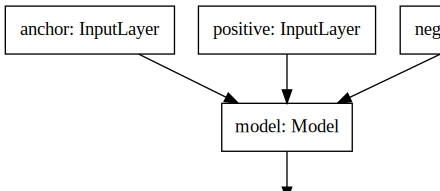

In [16]:
from IPython.display import SVG

SVG(tf.keras.utils.model_to_dot(model).create(prog='dot', format='svg'))

In [0]:
# Train the model (done over google colab) 
A, P, N = np.array(A), np.array(P), np.array(N)
triplets_np_array = np.array(triplets)

In [21]:
print(len(A))
print(A.shape)

906
(906, 224, 224, 3)


In [24]:
print(A.shape[0])
#print(np.zeros((A.shape[0],1)))

906


In [18]:
print(len(triplets))
#print(np.zeros((len(triplets),1)))

302


In [26]:
# Callback for Tensorboard and checkpoint
from tensorflow.keras.callbacks import ModelCheckpoint 

checkpoint = ModelCheckpoint(filepath='face_recog.weights.best.hdf5', verbose=1, 
                               save_best_only=False)

!mkdir -p logs/fit/
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model.fit([A, P, N], np.zeros((A.shape[0],1)),
                  epochs=10, batch_size=8, validation_split=0.3,
                  callbacks=[checkpoint, tensorboard_callback])


Epoch 1/10
80/80 [==============================] - ETA: 0s - loss: 2.5524 - mae: 1.5850
Epoch 00001: saving model to face_recog.weights.best.hdf5
80/80 [==============================] - 38s 476ms/step - loss: 2.5524 - mae: 1.5850 - val_loss: 2.5600 - val_mae: 1.6000
Epoch 2/10
80/80 [==============================] - ETA: 0s - loss: 2.5524 - mae: 1.5850
Epoch 00002: saving model to face_recog.weights.best.hdf5
80/80 [==============================] - 37s 461ms/step - loss: 2.5524 - mae: 1.5850 - val_loss: 2.5600 - val_mae: 1.6000
Epoch 3/10
80/80 [==============================] - ETA: 0s - loss: 2.5524 - mae: 1.5850
Epoch 00003: saving model to face_recog.weights.best.hdf5
80/80 [==============================] - 37s 458ms/step - loss: 2.5524 - mae: 1.5850 - val_loss: 2.5600 - val_mae: 1.6000
Epoch 4/10
80/80 [==============================] - ETA: 0s - loss: 2.5524 - mae: 1.5850
Epoch 00004: saving model to face_recog.weights.best.hdf5
80/80 [==============================] - 37s 4

In [15]:
!mkdir -p saved_model
new_model = model
new_model.save('saved_model/my_model') 


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved_model/my_model/assets


In [0]:
# zip saved model folder
!zip -r /content/saved_model.zip /content/saved_model

In [30]:
#print(new_model.get_input_shape_at(0))
print(new_model)
for node in model.outputs:
  print(node)

Tensor("lambda/Identity:0", shape=(1,), dtype=float32)


In [0]:
for layer in model.layers:
    print(layer)

In [27]:
print(model.layers)

[<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fdbb0519b70>, <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fdbb05305f8>, <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fdbb0519c18>, <tensorflow.python.keras.engine.training.Model object at 0x7fdbb022d5f8>, <tensorflow.python.keras.layers.core.Lambda object at 0x7fdbb022d9e8>]


## View on Tensorboard

In [0]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [0]:
%tensorboard --logdir logs/fit

In [17]:
tflite_model = tf.keras.models.load_model('saved_model/my_model')
converter = tf.lite.TFLiteConverter.from_keras_model(tflite_model)
tflite_save = converter.convert()
open("face_recog.tflite", "wb").write(tflite_save)

14248864

In [18]:
interpreter = tf.lite.Interpreter('face_recog.tflite')
#interpreter.allocate_tensors()

#input_details = interpreter.get_input_details()
print(interpreter.get_output_details())
interpreter.get_tensor_details()

[{'name': 'Identity', 'index': 336, 'shape': array([1], dtype=int32), 'shape_signature': array([1], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


[{'dtype': numpy.float32,
  'index': 0,
  'name': 'anchor',
  'quantization': (0.0, 0),
  'quantization_parameters': {'quantized_dimension': 0,
   'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32)},
  'shape': array([  1, 224, 224,   3], dtype=int32),
  'shape_signature': array([  1, 224, 224,   3], dtype=int32),
  'sparsity_parameters': {}},
 {'dtype': numpy.float32,
  'index': 1,
  'name': 'positive',
  'quantization': (0.0, 0),
  'quantization_parameters': {'quantized_dimension': 0,
   'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32)},
  'shape': array([  1, 224, 224,   3], dtype=int32),
  'shape_signature': array([  1, 224, 224,   3], dtype=int32),
  'sparsity_parameters': {}},
 {'dtype': numpy.float32,
  'index': 2,
  'name': 'negative',
  'quantization': (0.0, 0),
  'quantization_parameters': {'quantized_dimension': 0,
   'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32)},
  'shape': array([  1, 224

## Import image and verify

In [32]:
import os
from os.path import join as j
import numpy as np
import matplotlib.pyplot as plt



def detect_face(img):
    print(img)
  
    # Image to be resized to this shape
    (width, height) = (224, 224)     

    im = PIL.Image.open(img)
        # Creates images with normal color
        #im = cv2.imread('dataset/{}/photo{}.jpg'.format(sub_data,count))
    im = np.array(im)
        
    # Convert to grayscale
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY) 

    # Detect the face
    #faces = face_cascade.detectMultiScale(gray, 1.3, 4) 
 
    face_resize = cv2.resize(gray, (width, height))

    print(type(face_resize))
    print(face_resize.shape)
    
    return face_resize


def mean_squared_error(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred))


def verify_face(img, username):
    dir_ = 'dataset/faces_mixed'
    NUM_CLASSES = len(os.listdir(dir_))
    
    # The directory containing the user's photos
    pos_dir = username
    P_contents = os.listdir(os.path.join(dir_, pos_dir))
    print(P_contents)

    neg_dirs = [] #os.listdir(dir_)[np.random.randint(NUM_CLASSES)]

    for i in range(3):
        neg_dir = os.listdir(dir_)[np.random.randint(NUM_CLASSES)]
        while neg_dir == pos_dir or neg_dir in neg_dirs:
            neg_dir = os.listdir(dir_)[np.random.randint(NUM_CLASSES)]
        neg_dirs.append(neg_dir)

    print(neg_dirs)
            

    # Read images
    A = plt.imread(img)
    P_ran = P_contents[np.random.randint(0, len(P_contents))]
    P_str = plt.imread(join_(os.path.join(dir_, pos_dir), P_ran))    
    N1 = plt.imread(dir_ +'/'+ neg_dirs[0] +'/'+ os.listdir(dir_+'/'+neg_dirs[0])[-1])
    N2 = plt.imread(dir_ +'/'+ neg_dirs[1] +'/'+ os.listdir(dir_+'/'+neg_dirs[1])[-1])
    N3 = plt.imread(dir_ +'/'+ neg_dirs[2] +'/'+ os.listdir(dir_+'/'+neg_dirs[2])[-1])

    # Resize images
    A = cv2.resize(A,(224,224))
    P_str = cv2.resize(P_str, (224,224))
    N1 = cv2.resize(N1, (224,224))
    N2 = cv2.resize(N2, (224,224))
    N3 = cv2.resize(N3, (224,224))
    

    # Normalize pixels
    P = np.asarray(P_str)/255
    N1 = np.asarray(N1)/255
    N2 = np.asarray(N2)/255
    N3 = np.asarray(N3)/255
    
    # Reshape
    A = np.reshape(A,(1,224,224,3))
    P = np.reshape(P, (1,224,224,3))
    N1, N2, N3 = [np.reshape(N, (1,224,224,3)) for N in [N1, N2, N3]]

    print(A.shape)
    print(P.shape)
    print(N1.shape)


##########################################
    #new_model = tf.saved_model.load('saved_model/my_model')
    new_model = tf.keras.models.load_model('face_recog.weights.best.hdf5')
    #req_model = load_req_model('face_recog.weights.best.hdf5')
    req_model = VGG()

    enc_anc   = req_model(A)
    print(enc_anc)
    enc_pos   = req_model.predict(P)
    enc_neg_1 = req_model.predict(N1)
    enc_neg_2 = req_model.predict(N2)
    enc_neg_3 = req_model.predict(N3)

    enc_anc_N1   = new_model([A,P,N1])
    print()
    print(enc_anc_N1)

    enc_anc_N2   = new_model([A,P,N2])
    print(enc_anc_N2)

    enc_anc_N3   = new_model([A,P,N3])
    print(enc_anc_N3)
    
    # Normalizing the encodings to avoid large values
    maxm = np.max(enc_anc)
    enc_anc = enc_anc/maxm
    enc_pos = enc_pos/maxm
    enc_neg_1, enc_neg_2, enc_neg_3 = [enc/maxm for enc in [enc_neg_1, enc_neg_2, enc_neg_3]]

    positive_loss = mean_squared_error(enc_anc, enc_pos).numpy()
    print()
    print(positive_loss)
    negative_losses = [mean_squared_error(enc_anc, enc_neg).numpy() 
                        for enc_neg in [enc_neg_1, enc_neg_2, enc_neg_3]]
    print(negative_losses)

    # flag becomes false if the match is unsuccessful
    flag = True
    for neg_loss in negative_losses:
        if positive_loss > neg_loss:
            flag = False


    print(flag)
    
    return flag



# Here it is assumed that some app has provided with a webcam click called 'img' at the time of login.
# face_detected = detect_face('dataset/faces_mixed/george/photo0.jpg')  
# The username is provided at the time of login.
flag = verify_face('dataset/faces_mixed/george/photo0.jpg', 'george')

['photo14.jpg', 'photo19.jpg', 'photo1.jpg', 'photo3.jpg', 'photo13.jpg', 'photo17.jpg', 'photo18.jpg', 'photo2.jpg', 'photo4.jpg', 'photo16.jpg', 'photo8.jpg', 'photo0.jpg', 'photo10.jpg', 'photo9.jpg', 'photo7.jpg', 'photo5.jpg', 'photo11.jpg', 'photo6.jpg', 'photo12.jpg', 'photo15.jpg']
['voudcx', 'fordj', 'kaknig']
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
tf.Tensor(
[[-0.00691738 -0.00810604 -0.02112515 -0.00991471  0.01686451  0.00700816
  -0.0082172  -0.00731178 -0.0219101  -0.012657    0.01729987 -0.01665389
   0.00926385 -0.0085404  -0.00641035 -0.01377976  0.01401521 -0.00306641
  -0.01257238 -0.01682648 -0.0150544  -0.00958199  0.02156274 -0.02117084
   0.00978158 -0.01293385 -0.00643556 -0.00583393 -0.0050948  -0.00106749
  -0.01543518  0.00806005  0.00719344 -0.00668504 -0.01451225  0.00892266
   0.0037715  -0.00804185  0.01569305  0.00643883  0.01814491  0.02200679
   0.02093944 -0.00916435  0.00795163  0.01674937 -0.00140027 -0.01415666
   0.01964295  0.00716513